In [5]:
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import time
torch.set_float32_matmul_precision('high')

In [6]:
from dataclasses import dataclass

@dataclass
class Config:
    batch_size: int = 100
    learning_rate: float = 0.001
    epochs: int = 100
    n_embeddings: int = 100
    n_heads: int = 10
    n_layers: int = 10
    n_vocab: int = 10000
    n_ctx: int = 1024
    n_embd: int = 1024
    n_head: int = 10
    n_layer: int = 10
    n_vocab: int = 10000

In [7]:
%pip install -q datasets huggingface_hub pillow matplotlib


Note: you may need to restart the kernel to use updated packages.


In [8]:

from datasets import load_dataset
import torch
from torch.utils.data import DataLoader

print("Processing data in batches while streaming...")
dataset_stream = load_dataset("xcpan/MetaQuery_Instruct_2.4M_512res", split="train", streaming=True)

# Process in batches of 500
batch_size = 500
total_samples = 5000
processed = 0

for batch_num in range(total_samples // batch_size):
    print(f"\nStreaming batch {batch_num + 1}...")
    
    batch_samples = []
    for sample in dataset_stream.skip(batch_num * batch_size).take(batch_size):
        batch_samples.append(sample)
    
    print(f"  Downloaded {len(batch_samples)} samples")
    
    # Process this batch immediately (example: extract prompts)
    prompts = [s['prompt'] for s in batch_samples]
    print(f"  Processed {len(prompts)} prompts")
    
    
    processed += len(batch_samples)
    print(f"  Total processed: {processed}/{total_samples}")

print("\nStreaming and processing complete!")


Processing data in batches while streaming...


Resolving data files:   0%|          | 0/4257 [00:00<?, ?it/s]


Streaming batch 1...
  Downloaded 500 samples
  Processed 500 prompts
  Total processed: 500/5000

Streaming batch 2...
  Downloaded 500 samples
  Processed 500 prompts
  Total processed: 1000/5000

Streaming batch 3...
  Downloaded 500 samples
  Processed 500 prompts
  Total processed: 1500/5000

Streaming batch 4...
  Downloaded 500 samples
  Processed 500 prompts
  Total processed: 2000/5000

Streaming batch 5...
  Downloaded 500 samples
  Processed 500 prompts
  Total processed: 2500/5000

Streaming batch 6...
  Downloaded 500 samples
  Processed 500 prompts
  Total processed: 3000/5000

Streaming batch 7...
  Downloaded 500 samples
  Processed 500 prompts
  Total processed: 3500/5000

Streaming batch 8...
  Downloaded 500 samples
  Processed 500 prompts
  Total processed: 4000/5000

Streaming batch 9...
  Downloaded 500 samples
  Processed 500 prompts
  Total processed: 4500/5000

Streaming batch 10...
  Downloaded 500 samples
  Processed 500 prompts
  Total processed: 5000/5000


In [13]:
print(dataset_stream[0])

NotImplementedError: Subclasses of Dataset should implement __getitem__.

In [9]:
from datasets import load_dataset, Dataset, concatenate_datasets
import os
from itertools import islice

print("Loading MetaQuery_Instruct_2.4M_512res dataset in streaming mode...")
dataset_stream = load_dataset("xcpan/MetaQuery_Instruct_2.4M_512res", split="train", streaming=True)

dataset_stream_5k = dataset_stream.take(5000)

print("Example from streaming dataset:")
for i, sample in enumerate(dataset_stream_5k):
    if i == 0:
        print(f"Prompt: {sample['prompt']}")
        print(f"Target caption: {sample['target_caption']}")
    if i == 10:
        break

print("\n" + "="*50 + "\n")

print("Converting to regular Dataset (collecting 5000 samples)...")
samples = []
for idx, sample in enumerate(islice(dataset_stream.take(5000), 5000)):
    samples.append(sample)
    if (idx + 1) % 500 == 0:
        print(f"  Collected {idx + 1} samples...")

# Now convert to Dataset
dataset = Dataset.from_list(samples)
print(f"\nCreated Dataset with {len(dataset)} samples")


Loading MetaQuery_Instruct_2.4M_512res dataset in streaming mode...


Resolving data files:   0%|          | 0/4257 [00:00<?, ?it/s]

Example from streaming dataset:
Prompt: Generate the same device info screen as the source image, but for an iPad mini 3 that is not deregistered from the Apple ID account
Target caption: Unregister phone number from apple id.


Converting to regular Dataset (collecting 5000 samples)...
  Collected 500 samples...
  Collected 1000 samples...
  Collected 1500 samples...
  Collected 2000 samples...
  Collected 2500 samples...
  Collected 3000 samples...
  Collected 3500 samples...
  Collected 4000 samples...
  Collected 4500 samples...
  Collected 5000 samples...


KeyboardInterrupt: 

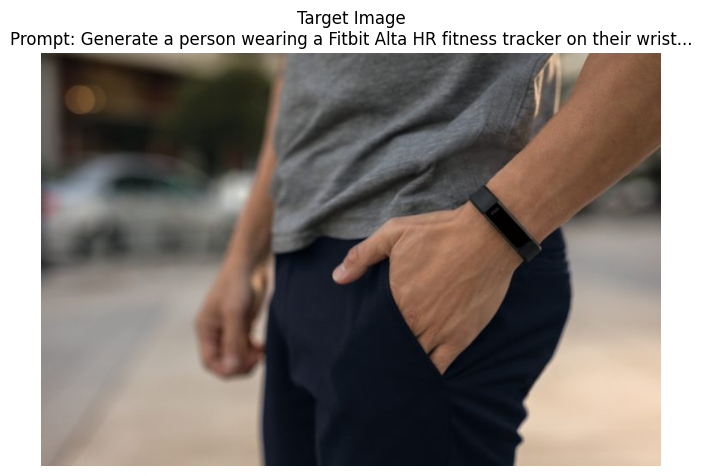

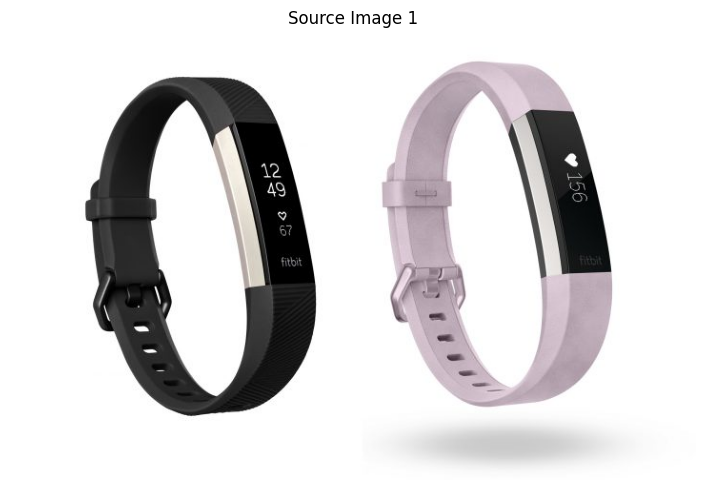

In [ ]:
sample = samples[69]

try:
    from PIL import Image
    import matplotlib.pyplot as plt
    
    # Get the target image
    target_image = sample['target_image']
    
    # Display target image
    plt.figure(figsize=(8, 6))
    plt.imshow(target_image)
    plt.title(f"Target Image\nPrompt: {sample['prompt'][:100]}...")
    plt.axis('off')
    plt.show()
    
    # Display source images
    source_images = sample['source_images']
    if source_images:
        fig, axes = plt.subplots(1, len(source_images), figsize=(15, 5))
        if len(source_images) == 1:
            axes = [axes]
        for i, img in enumerate(source_images):
            axes[i].imshow(img)
            axes[i].set_title(f"Source Image {i+1}")
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()
        
except ImportError:
    print("PIL or matplotlib not installed. Install them to visualize images:")
    print("%pip install pillow matplotlib")


In [10]:
# Convert the list of samples to a Dataset object for easier processing
from datasets import Dataset

# Create a Dataset object from the samples
dataset = Dataset.from_list(samples)
print(f"Created Dataset object with {len(dataset)} samples")
print(f"Features: {dataset.features}")

# Optional: Save the dataset locally for offline use
# Uncomment the following lines if you want to save the dataset

# dataset.save_to_disk("./metaquery_instruct_5k")
# print("Dataset saved locally to ./metaquery_instruct_5k")

# # To load from disk later:
# # from datasets import load_from_disk
# # dataset = load_from_disk("./metaquery_instruct_5k")


KeyboardInterrupt: 

In [ ]:

small_dataset = dataset.select(range(100))

for idx, sample in enumerate(small_dataset):
    if idx < 3:
        print(f"\nSample {idx + 1}:")
        print(f"Prompt: {sample['prompt']}")
        print(f"Target Caption: {sample['target_caption']}")
        print(f"Number of source images: {len(sample['source_images'])}")
        print("-" * 50)

try:
    from torch.utils.data import DataLoader
    
    # Create a DataLoader for batch processing
    dataloader = DataLoader(small_dataset, batch_size=4, shuffle=True)
    print(f"\nDataLoader created with batch size 4")
    print(f"Number of batches: {len(dataloader)}")
    
except ImportError:
    print("\nPyTorch not installed. Install it to use DataLoader:")
    print("%pip install torch")
